# Steps. Step by step.

This EDA is about steps. We will locate and visualize individual steps and construct the "step rate" and "current step duration" features. We will also find array indices for individual steps that can be used for further feature construction. 

Update:
There is a dataset of mine with discussed step-related features available. They are calculated for both TDCSFoG and DEFoG datasets with the same file structure as the training data.
https://www.kaggle.com/datasets/vrbaryshev/step-data


## Table of contents:
1. [Introduction](#Introduction)
2. [Discussing problems with AccV and AccAP and explaining why we'll want to use AccMl for step detection.](#Discussing)
3. [Visualizing steps: explaining the problem and suggesting continious wavelet transformation as a solution.](#Visualizing)
4. [Locating steps and constructing the "step rate" and "current step duration" features. We'll do it step by step.](#Locating)
5. [Summarizing it all in one "detect_steps" function.](#Summarizing)
6. [Testing the function and discussing some issues.](#Testing)
7. [Conclusion](#Conclusion)

# 1. Introduction <a name="Introduction"></a>

Steps are the core part of any walking. I believe and that step rate itself should be an important feature for identifying FoG and other features calculated over individual steps can be important too. However, correctly splitting the process of walking into individual steps solely with acceleration data might be a complicated task. In this article I've tried to create, thoroughly explain and discuss a reliable solution for that task.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import ceil
import scipy as sp
from scipy import signal
from scipy import fftpack
import pywt  # internet says pywt wavelets are better then scipy's. I'll believe that.
import tqdm
import re
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#defines
datasets_folder = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'
data_groups_names = ('tdcsfog', 'defog')
frequencies = (128, 100)

We'll read only tdcsfog data, as it'll be sufficient for the purpose of this EDA. I believe that the results are valid for other datasets too. Sorry for converting all the names to snake_case.

In [3]:
def read_data_file(test_id, subfolder_name = 'train/tdcsfog/'):
    data = pd.read_csv(datasets_folder+subfolder_name + str(test_id) + '.csv')
    data.columns = data.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()
    data = data.rename(columns={"acc_m_l": "acc_ml", "acc_a_p": "acc_ap"})
    return data

In [4]:
%%time
df_tdcsfog = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')
df_tdcsfog.columns = df_tdcsfog.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()
df_tdcsfog = df_tdcsfog.rename(columns={"acc_m_l": "acc_ml", "acc_a_p": "acc_ap"})

# adding 'data' column to the whole table, so we can have access to all of the time series's from one table
df_tdcsfog['data'] = df_tdcsfog['id'].apply(read_data_file)

CPU times: user 8.65 s, sys: 3.59 s, total: 12.2 s
Wall time: 25.4 s


# 2. Discussing problems with AccV and AccAP and explaining why we'll want to use AccML for step detection. <a name="Discussing"></a>
* AccV means vertical acceleration sensor data
* AccAP means forward-backward acceleration sensor data
* AccML means left-right acceleration sensor data

Intuitively, I began with looking at AccV, as it was supposed to measure vertical movements. I've never worked with biological data before, so I imagined a walking platform that steadily carries the sensors and keeps their orientation. The reality turned out to be different: people seem to lean forward a lot when they walk and they actively use that leaning techique to keep balance. As a result, the back-mounted sensor gets tilted (mostly) forward with constantly changing tilting angle. As a result, most of measured acceleration swings in AccV and AccAP correspond to the leaning (tilting) angle changes. Let us demonstrate that with some data:

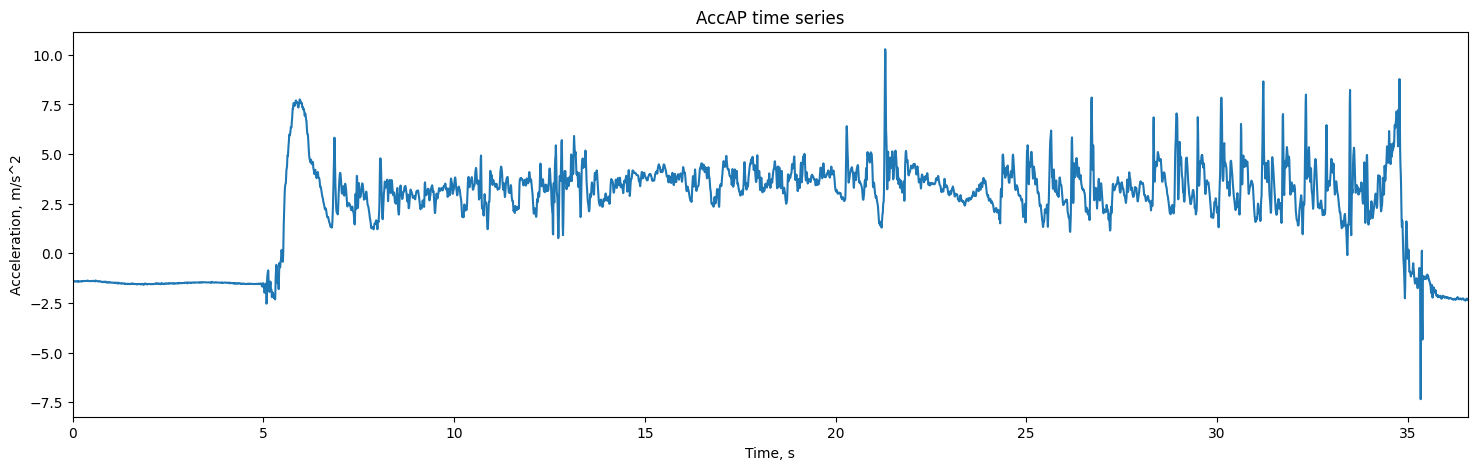

Average AccV is -9.151213668700747
Average AccAP is 2.471636634840753


In [5]:
subject = df_tdcsfog.loc[0,'data']   # we'll use the first patient in the database here for demonstration purposes
time = np.linspace(0, len(subject)/frequencies[0], len(subject))   

plt.figure(figsize=(18,5))
plt.plot(time, subject['acc_ap'])
plt.title('AccAP time series')
plt.gca().set_xlim(time[0], time[-1])
plt.gca().set_ylabel('Acceleration, m/s^2')
plt.gca().set_xlabel('Time, s')
plt.show()

print('Average AccV is',subject['acc_v'].mean())
print('Average AccAP is',subject['acc_ap'].mean())

As AccAP data tell us, sensor measures positive acceleration for almost the whole way. This would've meant constantly increasing speed if it was "real" forward acceleration. What we actually see here is projection of Earth's gravity force on the sensor's AP axis that gets there because the sensor gets tilted forward. Correspondigly, average AccV is less the g value because the V axis isn't actually vertical. As a result, AccAP and AccV mostly measure the tilting angle. We can also confirm this by calculating sum of their squares:

In [6]:
print('Average (AccV^2+AccAP^2)^0.5 - g =',((subject['acc_v']**2 + subject['acc_ap']**2)**0.5).mean() - 9.81)

Average (AccV^2+AccAP^2)^0.5 - g = -0.061068415041356516


So, mean sum of squares of $AccV{^2} + AccAP{^2}$ is very close to $g{^2}$. This also means that the AccML sensor is almost free of gravity force projection. So we'll want use AccML for detecting steps.

# 3. Visualizing steps: explaining the problem and suggesting continious wavelet transformation as a solution. <a name="Visualizing"></a>

Intuitively, steps seemed to be easy to locate. We have measurements of gait here and with steps being the core mechanic, they surely have to stand out in any measurements. Let us demonstrate some complications with a 5 second time window of AccML signal:

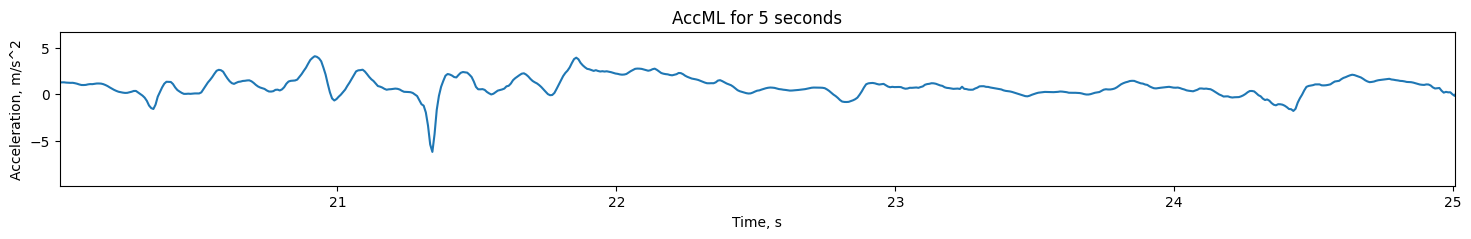

In [7]:
t1, t2 = 20*frequencies[0], 25*frequencies[0]
plt.figure(figsize=(18,2))
plt.plot(time, subject['acc_ml'])
plt.title('AccML for 5 seconds')
plt.gca().set_xlim(time[t1], time[t2])
plt.gca().set_ylabel('Acceleration, m/s^2')
plt.gca().set_xlabel('Time, s')
plt.show()

Intuitively, I expected AccML to cross zero back and forth on every step and thought about locating thouse crossings to measure steps. This random 5 second walking interval shows a different picture. Signal has all kind of noises and random oscillations and steps don't visually stand out at all. We are supposed to see about 10 steps in 5 seconds, by the way. But with that kind of signal we'll need some kind of spectral approach to detect them. Let us briefly look at what Fourier transformation results in for the whole session:

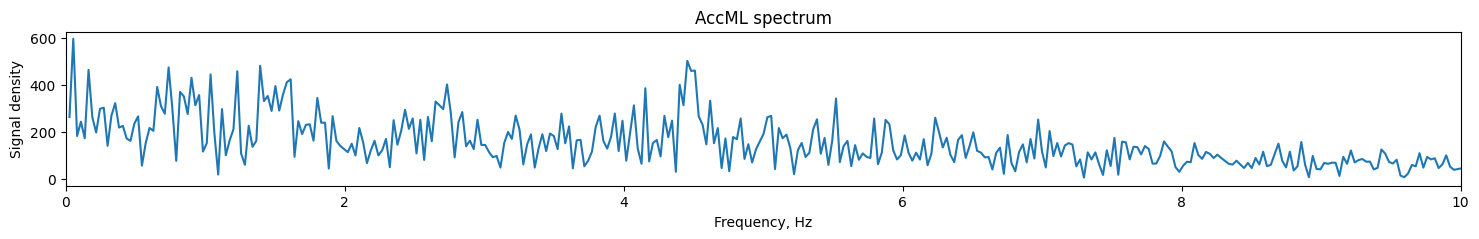

In [8]:
temp_fft = fftpack.fft(subject['acc_ml'].values)    # this gives the Fourier transformation
fftfreq = fftpack.fftfreq(len(temp_fft), 1. / frequencies[0])  # this makes frequency values for points in temp_fft
i = fftfreq > 0

plt.figure(figsize=(18,2))
plt.plot(fftfreq[i], abs(temp_fft[i]))
plt.title('AccML spectrum')
plt.gca().set_xlim(0, 10)
plt.gca().set_ylabel('Signal density')
plt.gca().set_xlabel('Frequency, Hz')
plt.show()

As the graph shows, the spectrum isn't smooth and nice at all and doesn't give any outstanding step frequency. We should expect this as the whole time graph has about 35 seconds in it with and includes standing up, acceleration, walking, deceleration and possible FoG events. We'll want to look at smaller time windows to analyze walking as our goal is to locate and describe every step. So we'll use continious wavelet transformation (CWT) to make steps vizible:

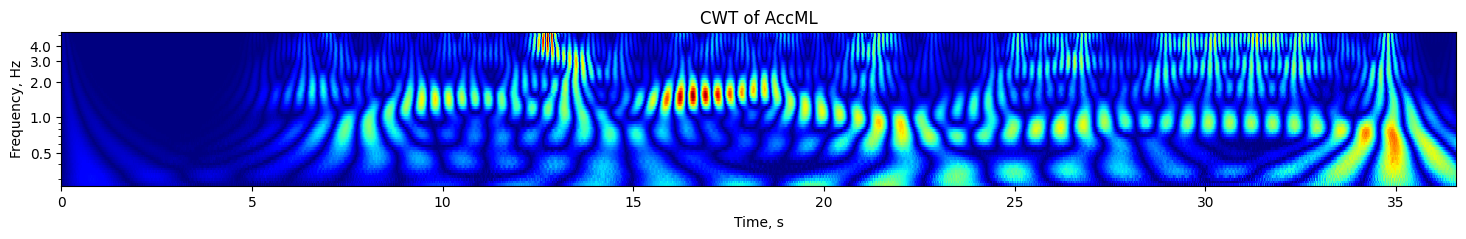

In [9]:
wavelet='morl'       # we'll use Morlet wavelet
scales = np.exp(np.arange(3, 6, 0.05))   # wavelet scales define the frequency values we get
# continious wavelet transformation from pywt library
# coeff gives how much of each frequency we have at each time moment
# freq is the corresponding list of frequency values
coeff, freq = pywt.cwt(subject['acc_ml'], scales, wavelet)

plt.figure(figsize=(18,2))
plt.title('CWT of AccML')
plt.pcolormesh(time, freq*frequencies[0], abs(coeff), cmap='jet')
plt.gca().set_yscale('log')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.yticks(ticks=[0.5, 1, 2, 3, 4])
plt.gca().set_ylabel('Frequency, Hz')
plt.gca().set_xlabel('Time, s')
plt.show()

And here we see the steps! Well, mostly) Hopefully) They are presented as a chain of green spots around frequency of 1 Hz. It is known that humans walk at about 2 Hz and we see exactly that, because the patient makes and the graph describes two steps per AccML cycle, one with each leg. Now let us locate and count them.

# 4. Locating steps and constructing the "step rate" and "current step duration" features. <a name="Locating"></a>
#### *We'll do it step by step )*

So we want to extract the green dots from the above graph and present them as features. Let us start with locating the maximum absolute value of CWT at each time slice:

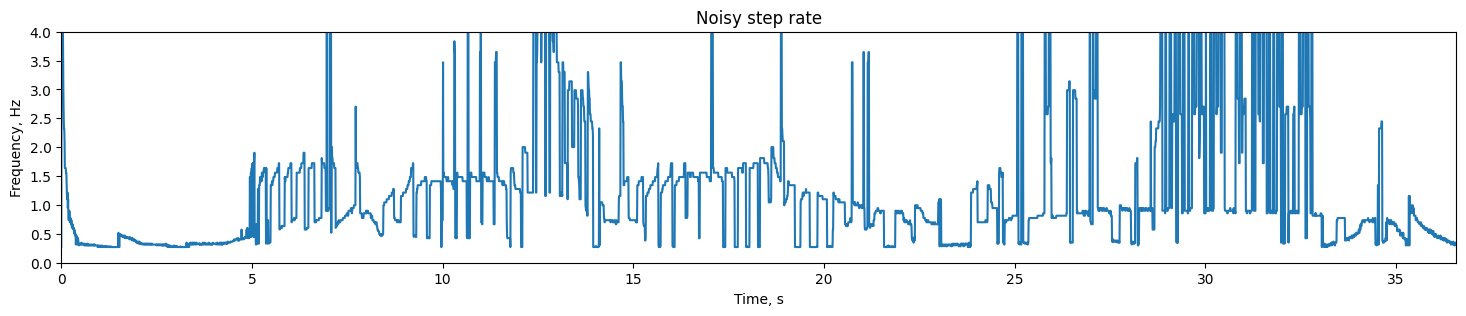

In [10]:
coeff_argmax_index = np.argmax(abs(coeff), 0)

plt.figure(figsize=(18,3))
plt.plot(time, freq[coeff_argmax_index]*128)
plt.title('Noisy step rate')
plt.gca().set_xlim(time[0], time[-1])
plt.gca().set_ylim(0, 4)
plt.gca().set_ylabel('Frequency, Hz')
plt.gca().set_xlabel('Time, s')
plt.show()

This is our step rate. It is actually quite real, but a bit noisy at this time. It also jumps and drops to wrong frequency values a lot. We'll have to clear it. Now that is a bit tricky point. Slices of CWT image along any horizontal line give us our signal at that frequency. This is  somewhat like a frequency filter. So we'll make a slice of CWT along the line composed by our maximum image value array. We'll believe that it represents the step-related part of our original AccML data:

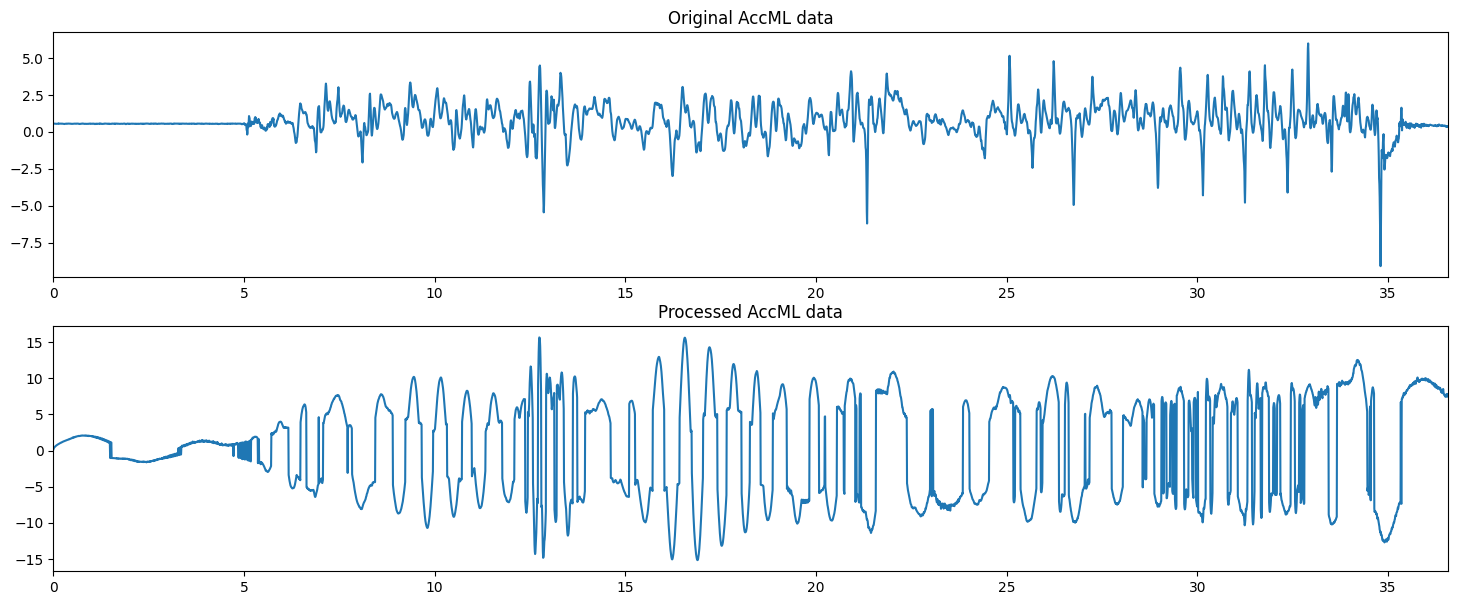

In [11]:
coeff_max = np.array([coeff[coeff_argmax_index[i], i] for i in range(coeff.shape[1])])

fig,ax=plt.subplots(2,1,figsize=(18,7))
ax[0].set_title('Original AccML data')
ax[0].plot(time, subject['acc_ml'])
ax[0].set_xlim(time[0], time[-1])
ax[1].set_title('Processed AccML data')
ax[1].plot(time, coeff_max)
ax[1].set_xlim(time[0], time[-1])
plt.show()

This processed data visibly corresponds to most of the steps and actually crosses zero all the time. We can locate those crossings and count steps, but first we want to correct errors. Partly, the errors are pretty obvious: some steps are way too wide, while the ones next to them are super short.  Also, there are sharp turns of the signal line. We believe that the graph has all the necessary frequency information, but is noisy. We'll clear it again with the same CWT:

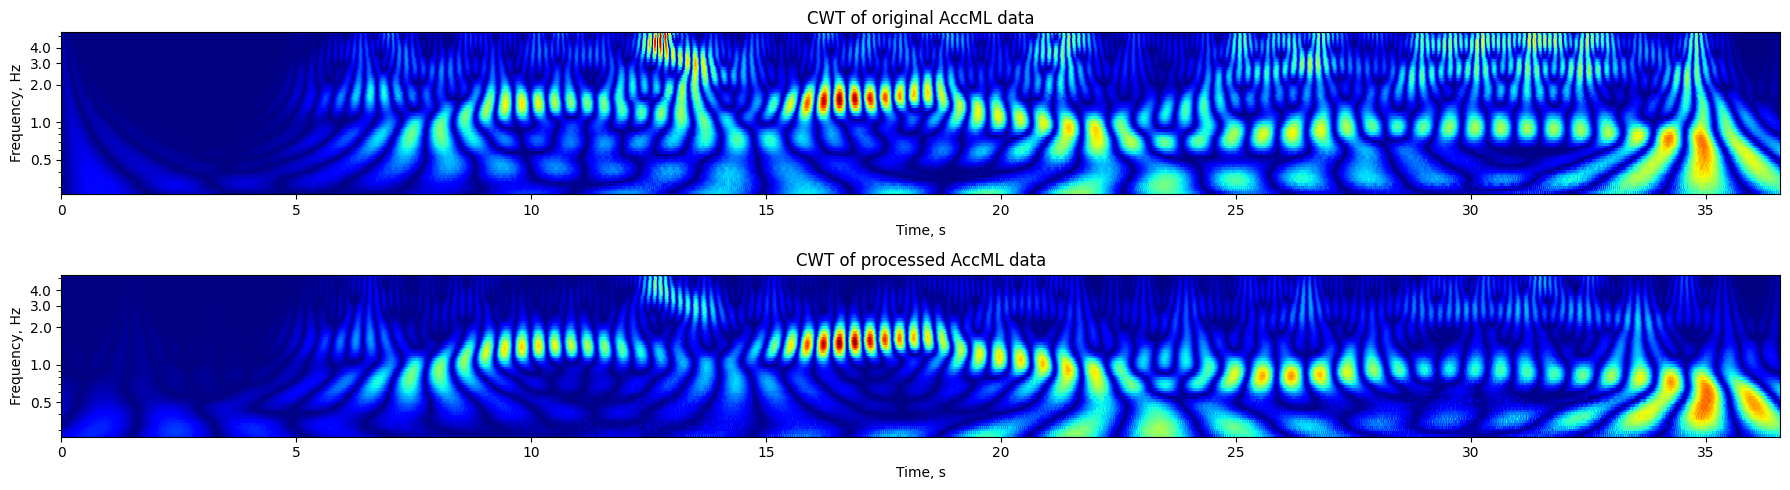

In [12]:
coeff_2, freq = pywt.cwt(coeff_max, scales, wavelet)

fig,ax=plt.subplots(2,1,figsize=(18,5))

ax[0].set_title('CWT of original AccML data')
ax[0].pcolormesh(time, freq*frequencies[0], abs(coeff), cmap='jet')
ax[1].set_title('CWT of processed AccML data')
ax[1].pcolormesh(time, freq*frequencies[0], abs(coeff_2), cmap='jet')

for axx in ax:
    plt.sca(axx)
    axx.set_xlim(time[0], time[-1])
    axx.set_ylabel('Frequency, Hz')
    axx.set_yscale('log')
    axx.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.yticks(ticks=[0.5, 1, 2, 3, 4])
    axx.set_xlabel('Time, s')
plt.tight_layout()
plt.show()

Now we have a much clearer view. Steps are there and a lot of noise is gone. Let us collect the data along the maximum CWT image line:

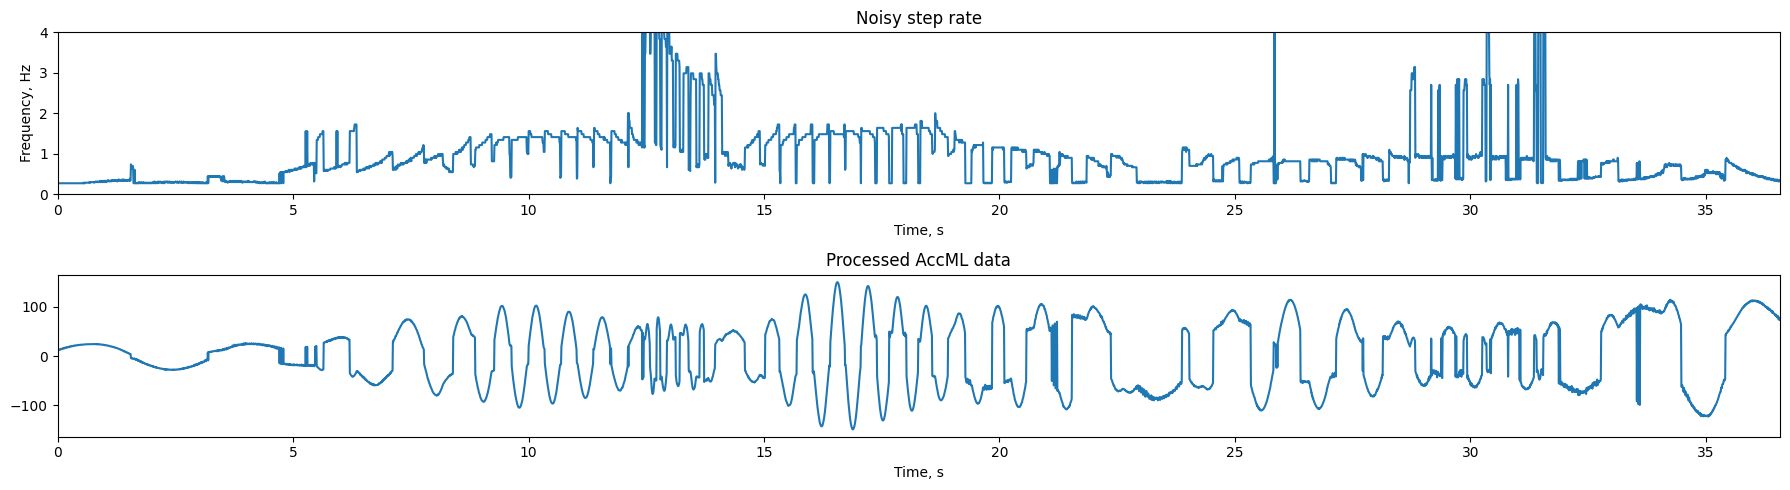

In [13]:
coeff_argmax_index_2 = np.argmax(abs(coeff_2), 0)
coeff_max_2 = np.array([coeff_2[coeff_argmax_index_2[i], i] for i in range(coeff_2.shape[1])])

fig,ax=plt.subplots(2,1,figsize=(18,5))
ax[0].set_title('Noisy step rate')
ax[0].plot(time, freq[coeff_argmax_index_2]*128)
ax[0].set_xlim(time[0], time[-1])
ax[0].set_ylim(0, 4)
ax[0].set_ylabel('Frequency, Hz')
ax[1].set_title('Processed AccML data')
ax[1].plot(time, coeff_max_2)
for axx in ax:
    axx.set_xlim(time[0], time[-1])
    axx.set_xlabel('Time, s')
plt.tight_layout()
plt.show()

The step rate became less noisy and processed ML data contains less errors. We have a problem in those graphs: np.argmax of CWT data pushes us back and forth between frequency bands. We want to stay in one band that represents steps and we believe that it is the most represented band. So we'll let the majority vote for the band by going for median:

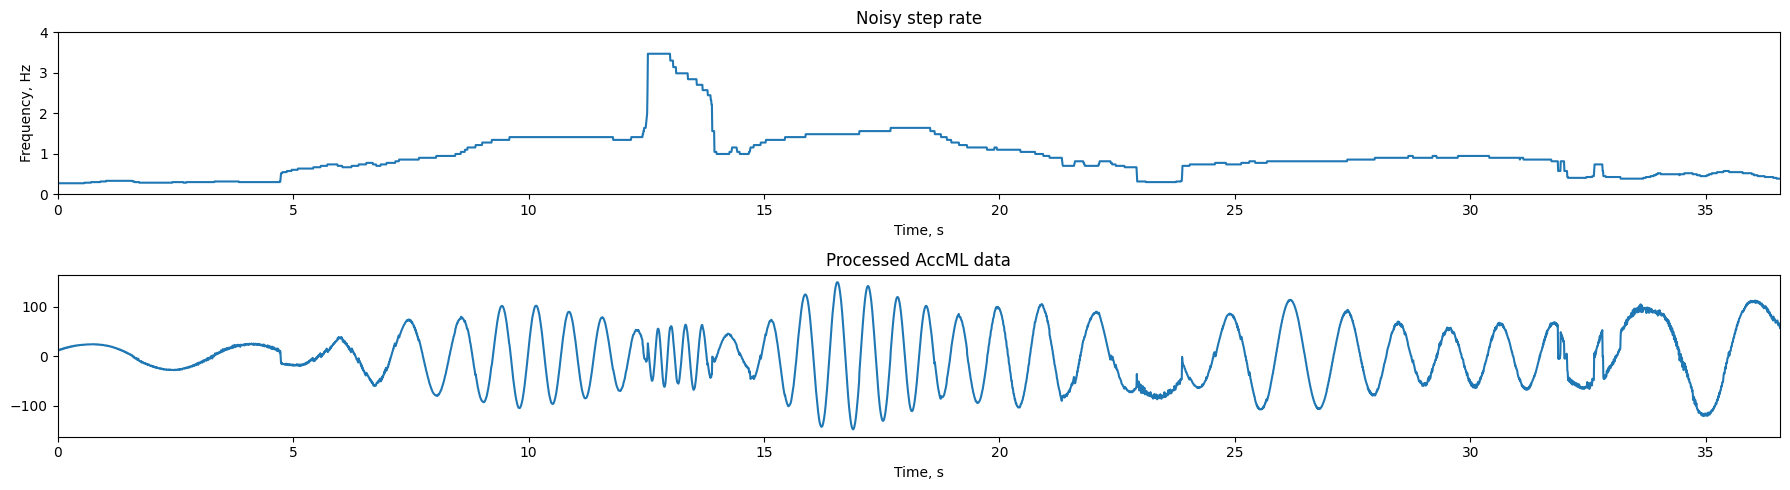

In [14]:
coeff_argmax_index_21 = np.round(pd.Series(coeff_argmax_index_2).rolling(128, center=True, min_periods=1).median()).astype(int)
coeff_max_21 = np.array([coeff_2[coeff_argmax_index_21[i], i] for i in range(coeff_2.shape[1])])

fig,ax=plt.subplots(2,1,figsize=(18,5))
ax[0].set_title('Noisy step rate')
ax[0].plot(time, freq[coeff_argmax_index_21]*128)
ax[0].set_xlim(time[0], time[-1])
ax[0].set_ylim(0, 4)
ax[0].set_ylabel('Frequency, Hz')
ax[1].set_title('Processed AccML data')
ax[1].plot(time, coeff_max_21)
for axx in ax:
    axx.set_xlim(time[0], time[-1])
    axx.set_xlabel('Time, s')
plt.tight_layout()
plt.show()

This is much smoother. We can repeat the procedure for more smoothness:

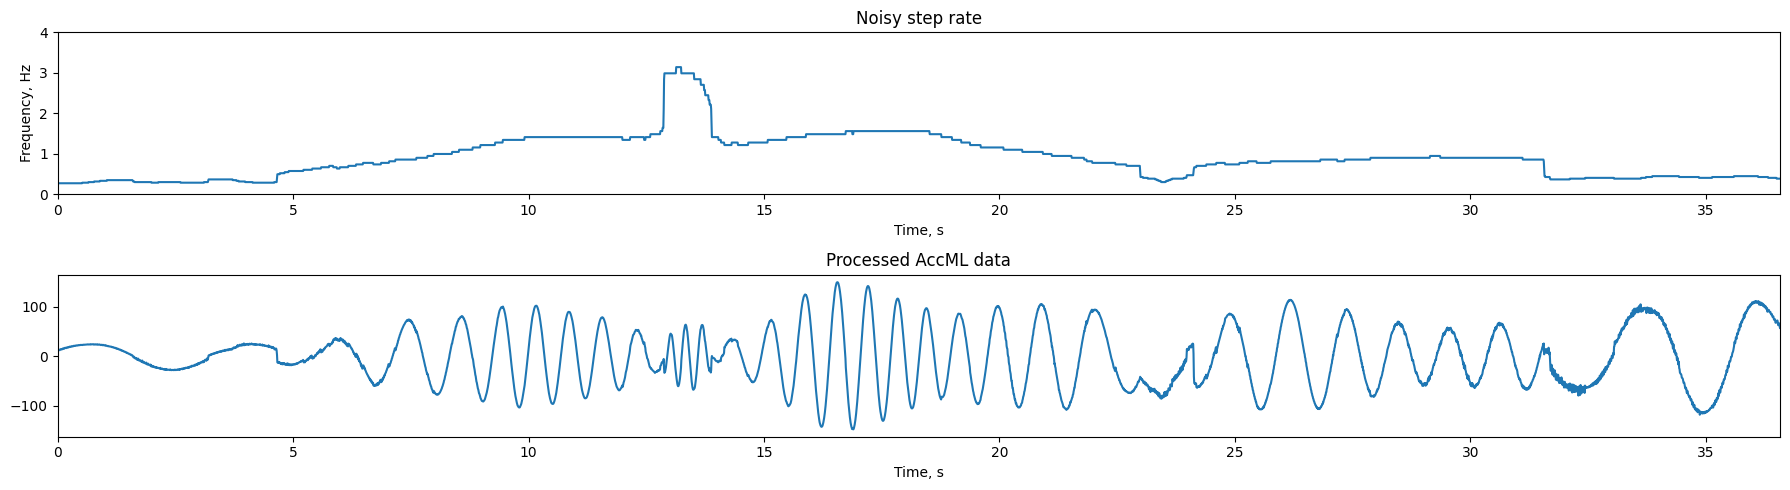

In [15]:
coeff_3, freq = pywt.cwt(coeff_max_21, scales, wavelet)
coeff_argmax_index_3 = np.argmax(abs(coeff_3), 0)
coeff_argmax_index_31 = np.round(pd.Series(coeff_argmax_index_3).rolling(128, center=True, min_periods=1).median()).astype(int)
coeff_max_31 = np.array([coeff_2[coeff_argmax_index_31[i], i] for i in range(coeff_2.shape[1])])

fig,ax=plt.subplots(2,1,figsize=(18,5))
ax[0].set_title('Noisy step rate')
ax[0].plot(time, freq[coeff_argmax_index_31]*128)
ax[0].set_xlim(time[0], time[-1])
ax[0].set_ylim(0, 4)
ax[0].set_ylabel('Frequency, Hz')
ax[1].set_title('Processed AccML data')
ax[1].plot(time, coeff_max_31)
for axx in ax:
    axx.set_xlim(time[0], time[-1])
    axx.set_xlabel('Time, s')
plt.tight_layout()
plt.show()

But, inevitably, we'll need to somehow decide between two (equally) represented frequency bands. Also, as we are picking the brightest dots along each time slice, we are doomed to pick wrong data between steps when our step band is empty. So we'll use find_peaks() from numpy to detect bigger, wider and distant from each other peaks on our processed AccML data line and make another data array that is located along this peak line. We interpolate data in index space here:

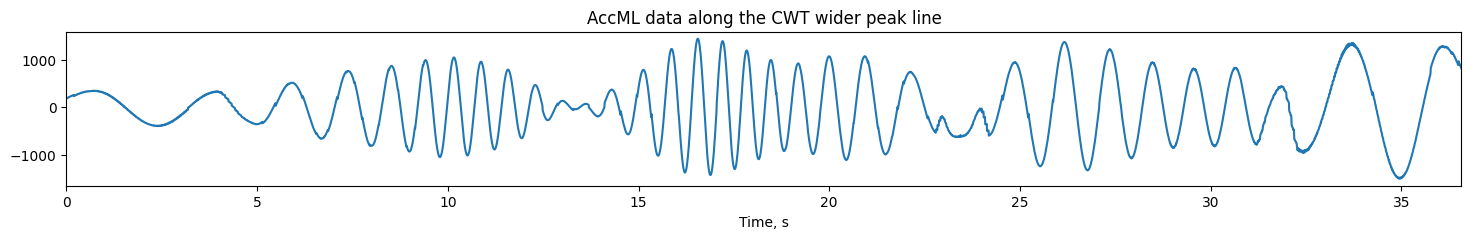

In [16]:
max_cwt_points = sp.signal.find_peaks(abs(coeff_max_31), distance=20, width=20)[0]
max_cwt_points = np.concatenate(([0], max_cwt_points, [len(coeff_max_31)-1]))
# and interpolating our line in wavelet space between the bigger peaks
max_cwt_line_indexes = np.round(np.interp( range(0, len(coeff_max_31)), max_cwt_points, 
                                                    coeff_argmax_index_31[max_cwt_points])).astype(int)
coeff_line = np.array([coeff_3[max_cwt_line_indexes[i], i] for i in range(coeff.shape[1])])

plt.figure(figsize=(18,2))
plt.plot(time, coeff_line)
plt.title('AccML data along the CWT wider peak line')
plt.gca().set_xlim(time[0], time[-1])
plt.gca().set_xlabel('Time, s')
plt.show()

Now, since we used a smooth interpolated line in index space, our processed AccML data is reasonably smooth. Let us check where it crosses zero and locate the steps:

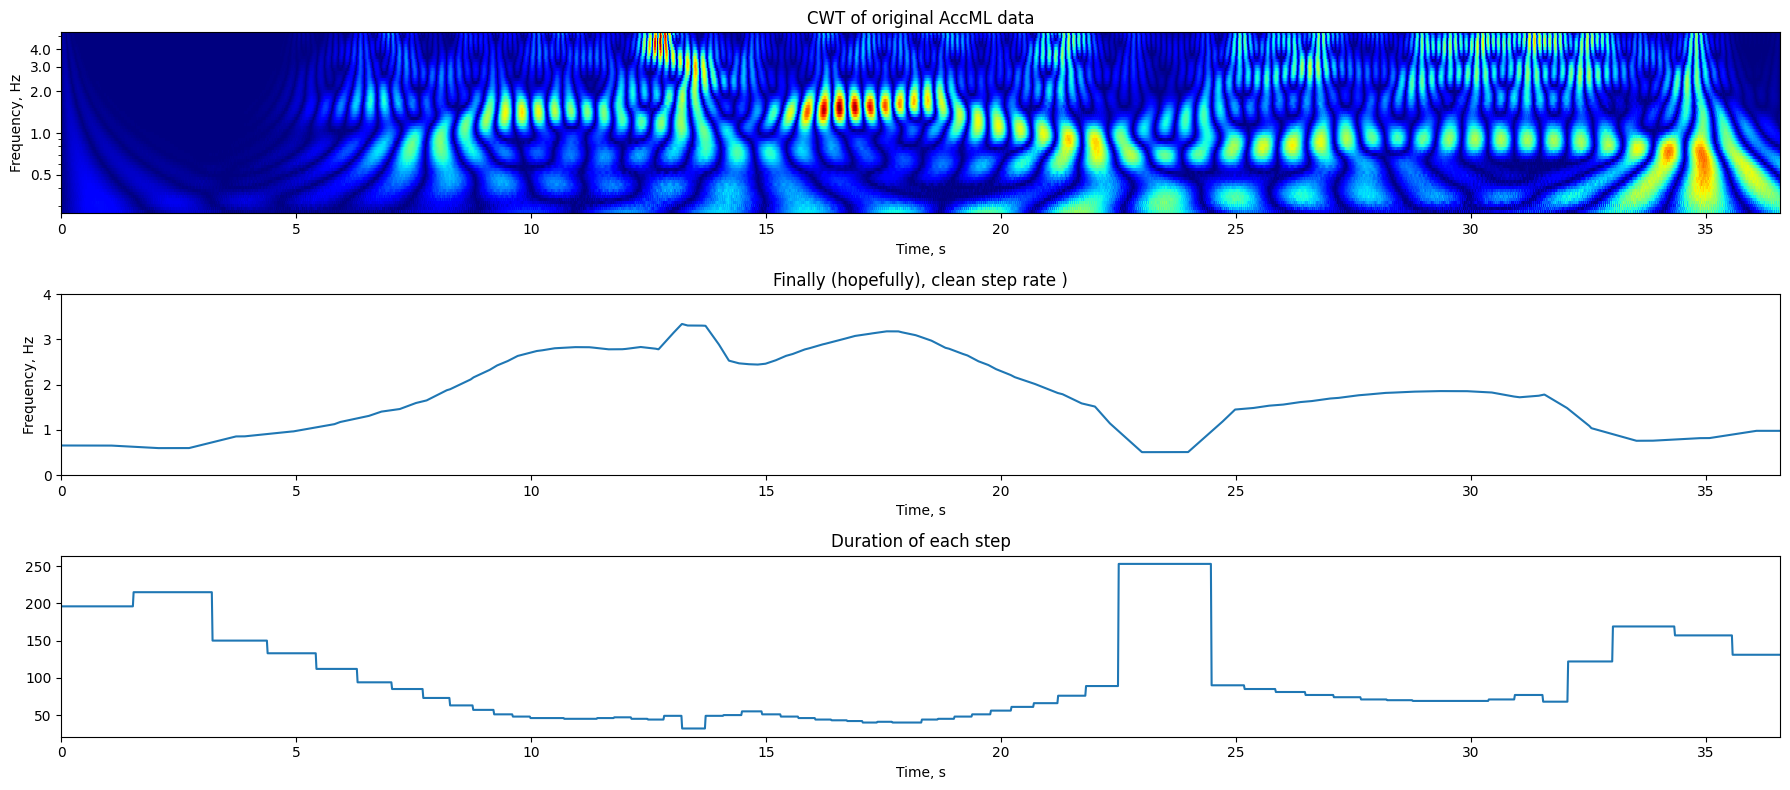

In [17]:
zero_crossings = np.where( np.diff(np.sign(pd.Series(coeff_line).rolling(10, center=True, min_periods=1).mean())))[0]
zero_crossings = np.concatenate( ([0], zero_crossings, [len(coeff_line)]))    
#filling each step with its duration while cutting possible outbursts with median
step_lengths = []
for i in range(1, len(zero_crossings)):
    step_lengths = np.concatenate( (step_lengths, [zero_crossings[i] - zero_crossings[i-1]]*(zero_crossings[i] - zero_crossings[i-1]) ))
step_durations = pd.Series(step_lengths).rolling(32, center=True, min_periods=1).median()
# making a nice and smooth step_rate array
step_rate = pd.Series( 1./step_durations )*frequencies[0]
step_rate = step_rate.where(step_rate<5, 0).rolling(frequencies[0], center=True, min_periods=1).mean()

fig,ax=plt.subplots(3,1,figsize=(18,8))
ax[0].set_title('CWT of original AccML data')
ax[0].pcolormesh(time, freq*frequencies[0], abs(coeff), cmap='jet')
ax[0].set_ylabel('Frequency, Hz')
ax[0].set_yscale('log')
ax[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.sca(ax[0])
plt.yticks(ticks=[0.5, 1, 2, 3, 4])
ax[1].set_title('Finally (hopefully), clean step rate )')
ax[1].plot(time, step_rate)
ax[1].set_xlim(time[0], time[-1])
ax[1].set_ylim(0, 4)
ax[1].set_ylabel('Frequency, Hz')
ax[2].set_title('Duration of each step')
ax[2].plot(time, step_durations)
for axx in ax:
    axx.set_xlim(time[0], time[-1])
    axx.set_xlabel('Time, s')
plt.tight_layout()
plt.show()

Well, almost. We have steps. Our step rate is smooth and generally corresponds to the image. There are 3 visible problems on that graph:
* wrong short step at the 14th second
* wrong long step at the 23rd second
* extra steps in the beginning

Appearace of extra steps when there is no actual walking is to be solved by some sort of an "if_walking" filter. Currently, this is out of the scope of this EDA. But it might be added later. The first two problems are to be discussed after we collect the whole procedure in one function that we can use.

# 5. Summarizing it all in one "detect_steps" function. <a name="Summarizing"></a>

#### Parameters:
* ***signal*** is a time series to detect steps from. I recommend the AccML data.
* ***frequency*** is the signal frequency in Hz, which is 128 for our data, but different for the other dataset
* ***smoothing*** is the number of wavelet smoothing cycles. I've seen artifacts that appear on 1 and disappear on 2.
* ***faster_please*** is an option to skip the find_peaks stage. It creates artifacts, so I don't recommend it.
* ***min_scale_log*** and ***max_scale_log*** determine the frequency band for all the CWT's. Wider is for handling far-off steprates, narrower is to avoid band miscalculations like on the graph above.

#### Return value:
* ***step_rate*** pd.Series with a smooth step rate value for every time point in dataset
* ***step_durations*** pd.Series with flat plates as high as step duration in seconds as a time series for every time point in dataset
* ***zero_crossings*** np.array with indices of time point that mark beginnings of new steps

All parameters except the signal have my suggested default values. Steps are considered to begin and end with two feet on the ground and the body weighting them equally. Some might consider those moments to be middles of steps and recalculate steps in a different way.


In [18]:
def detect_steps(signal, frequency=128, smoothing=2, faster_please=False, min_scale_log=3.6, max_scale_log=5.4):
    
    # scales for wavelets that define frequencies, exp for more even distribution
    # choosing border values is tricky
    # too narrow and we lose some slow or fast steprates
    # too wide and we get the steprate wrong for unusual walking wavelet spectrum cases
    # check patient #6 in the tdcsfog dataset as an example of an unusual pattern
    scales = np.exp(np.arange(min_scale_log, max_scale_log, 0.05))
    wavelet='morl'  # chosing the Morlet wavelet
    
    # transforming the signal, preferrably the 'AccMl' one
    coeff, freq = pywt.cwt(signal, scales, wavelet)
    # finding the brightest dots on every time slice
    coeff_argmax_index = np.argmax(abs(coeff), 0)
    # and collecting their coeff values in a new "signal", which already looks like our step rate, but is a bit noisy
    coeff_max = np.array([coeff[coeff_argmax_index[i], i] for i in range(coeff.shape[1])])
    
    # repeating the smoothing procedure
    for i in range(smoothing):
        # transforming the noisy step rate again to clear it
        coeff, freq = pywt.cwt(coeff_max, scales, wavelet)
        # finding the brightest dots on every time slice
        coeff_argmax_index = np.argmax(abs(coeff), 0).astype(int)
        # and smoothing their indices with median to cut some outbursts off
        coeff_argmax_index = np.round(pd.Series(coeff_argmax_index).rolling(128, center=True, min_periods=1).median()).astype(int)
        # collecting the values along our line of indices
        coeff_max = np.array([coeff[coeff_argmax_index[i], i] for i in range(coeff.shape[1])])
    
    # this smoothing round is optional
    if not faster_please:
        # finding hopefully bigger peaks on our line
        # hopefully skiping too narrow or too close ones that are likely to be outbursts
        max_cwt_points = sp.signal.find_peaks(abs(coeff_max), distance=20, width=20)[0]
        max_cwt_points = np.concatenate(([0], max_cwt_points, [len(signal)-1]))
        # and interpolating our line in wavelet space between the bigger peaks
        max_cwt_line_indexes = np.round(np.interp( range(0, len(signal)), max_cwt_points, 
                                                    coeff_argmax_index[max_cwt_points])).astype(int)
        coeff_max = np.array([coeff[max_cwt_line_indexes[i], i] for i in range(coeff.shape[1])])
    
    # finding zeroes on this smooth line to separate individual steps from other steps    
    zero_crossings = np.where( np.diff(np.sign(pd.Series(coeff_max).rolling(10, center=True, min_periods=1).mean())))[0]
    zero_crossings = np.concatenate( ([0], zero_crossings, [len(signal)]))    
    #filling each step with its duration while cutting possible outbursts with median
    step_lengths = []
    for i in range(1, len(zero_crossings)):
        step_lengths = np.concatenate( (step_lengths, [zero_crossings[i] - zero_crossings[i-1]]*(zero_crossings[i] - zero_crossings[i-1]) ))
    step_durations = pd.Series(step_lengths).rolling(32, center=True, min_periods=1).median()
    # making a nice and smooth step_rate array
    step_rate = pd.Series( 1./step_durations )*frequency
    step_rate = step_rate.where(step_rate<5, 0).rolling(frequency, center=True, min_periods=1).mean()
    
    return step_rate, step_durations, zero_crossings

This function is autonomous and "copy&paste" friendly. It is for everyone to use, but please upvote this work if you use it and mention me in credits.

# 6. Testing the function and discussing some issues. <a name="Testing"></a>

Let us make a tool for displaying test results:

In [19]:
def feature_display(subject, faster_please=False, smoothing=2, min_scale_log=3.6, max_scale_log=5.4 ):

    signal = subject['acc_ml']  
    time = np.linspace(0, len(signal)/frequencies[0], len(signal)) 
    scales = np.exp(np.arange(min_scale_log, max_scale_log, 0.05))
    wavelet='morl'
    coeff, freq = pywt.cwt(signal, scales, wavelet)
    print('Min frequency =', np.min(freq)*frequencies[0])
    print('Max frequency =', np.max(freq)*frequencies[0])
    
    step_rate, step_durations, step_borders = detect_steps(subject['acc_ml'], 
                                                               frequency=frequencies[0], 
                                                               faster_please=faster_please,
                                                              min_scale_log=min_scale_log,
                                                              max_scale_log=max_scale_log)
    
    fig,ax=plt.subplots(3,1,figsize=(18,7))
    
    ax[0].set_title('AccML CWT data')
    ax[0].pcolormesh(time, freq*frequencies[0], abs(coeff), cmap='jet')
    ax[0].set_ylabel('Frequency, Hz')
    ax[0].set_yscale('log')
    ax[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.sca(ax[0])
    plt.yticks(ticks=[0.5, 1, 2, 3, 4])
    
    ax[1].set_title('Step rate')
    ax[1].plot(time, step_rate)
    ax[1].set_xlim(time[0], time[-1])
    ax[1].set_ylim(0, 5)
    ax[1].set_ylabel('Frequency, Hz')
    
    ax[2].set_title('Step durations')
    ax[2].plot(time, step_durations/frequencies[0])
    ax[2].set_xlim(time[0], time[-1])
    ax[2].set_ylim(0, 1.5)
    ax[2].set_ylabel('Time, s')
    
    plt.tight_layout()
    plt.show()

Now we can test the function. Let us begin with our initial case, the first patient in our data:

Min frequency = 0.4938077039387963
Max frequency = 2.8416671345184263


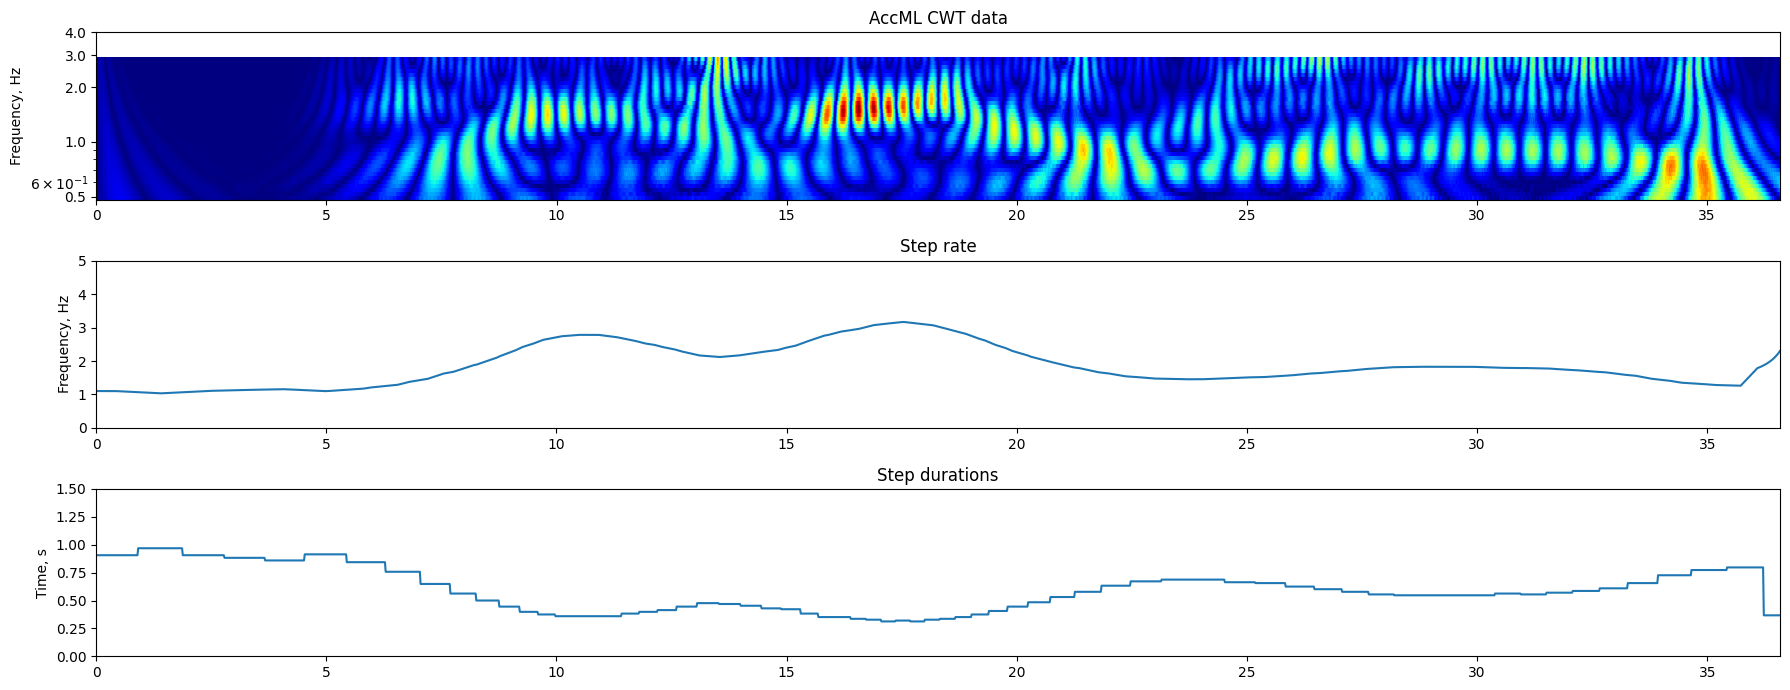

In [20]:
feature_display(df_tdcsfog.loc[0,'data'])

As we can see, this step rate is correct and both miscalculated steps that were present in the "step by step" chapter are now gone. This is because the frequency band we used here is narrower. Choice of that band is delicate. Wide band leads to mistakes and narrow one screws at high or low step rate series. Let us test some more series:

Min frequency = 0.4938077039387963
Max frequency = 2.8416671345184263


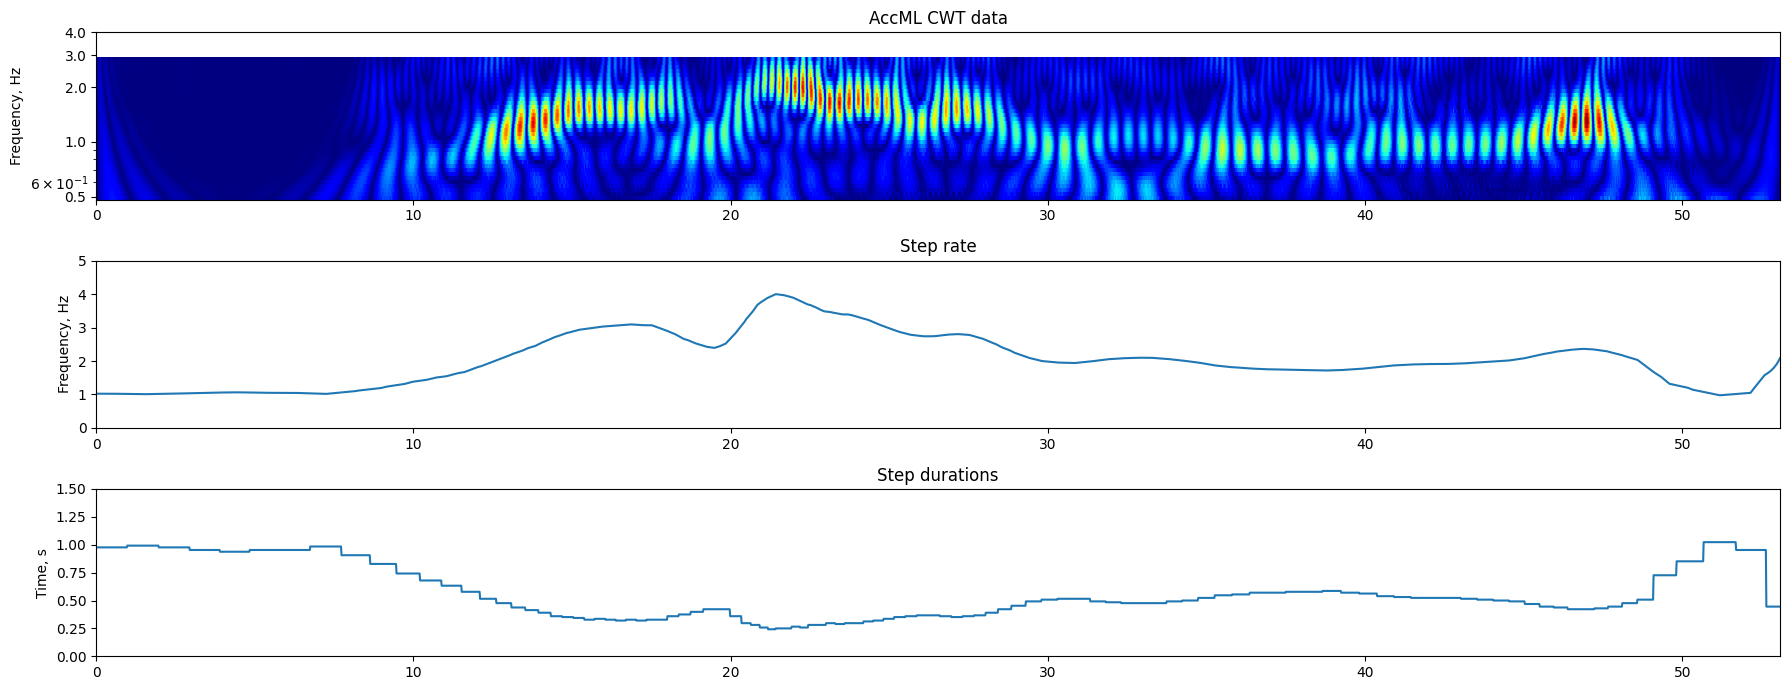

In [21]:
feature_display(df_tdcsfog.loc[100,'data'])

Min frequency = 0.4938077039387963
Max frequency = 2.8416671345184263


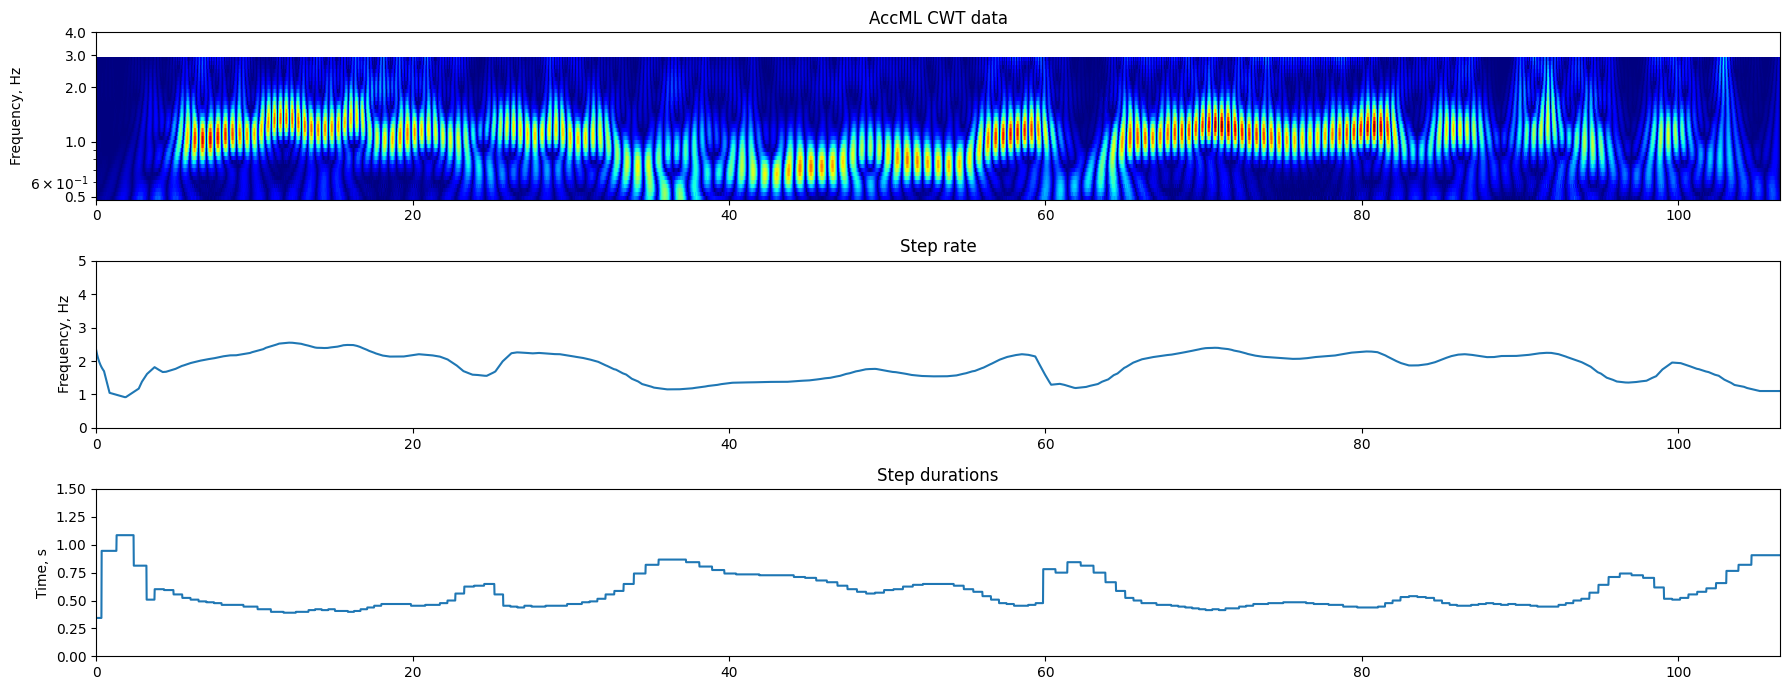

In [22]:
feature_display(df_tdcsfog.loc[11,'data'])

Min frequency = 0.4938077039387963
Max frequency = 2.8416671345184263


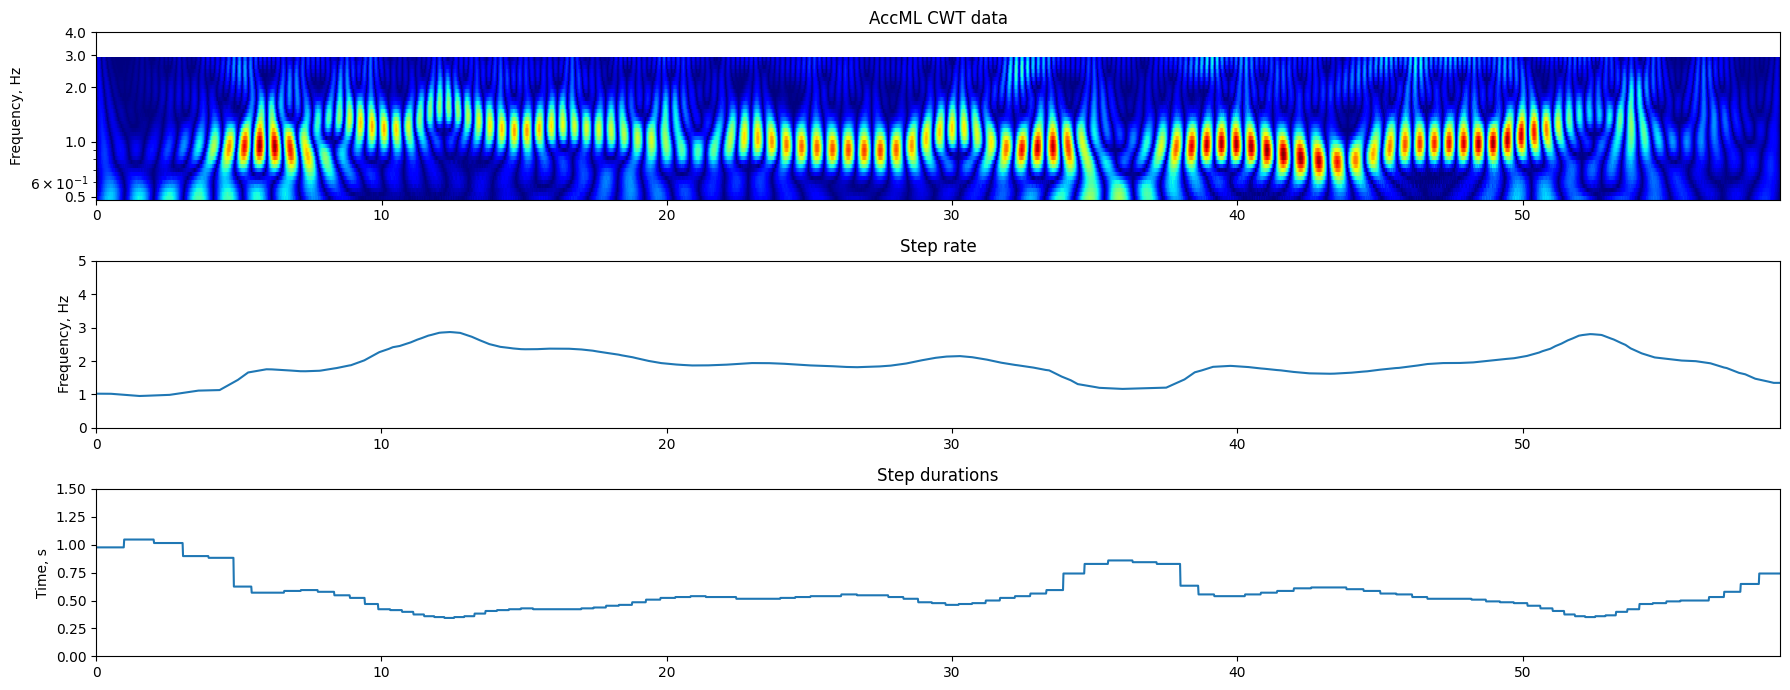

In [23]:
feature_display(df_tdcsfog.loc[14,'data'])

Min frequency = 0.4938077039387963
Max frequency = 2.8416671345184263


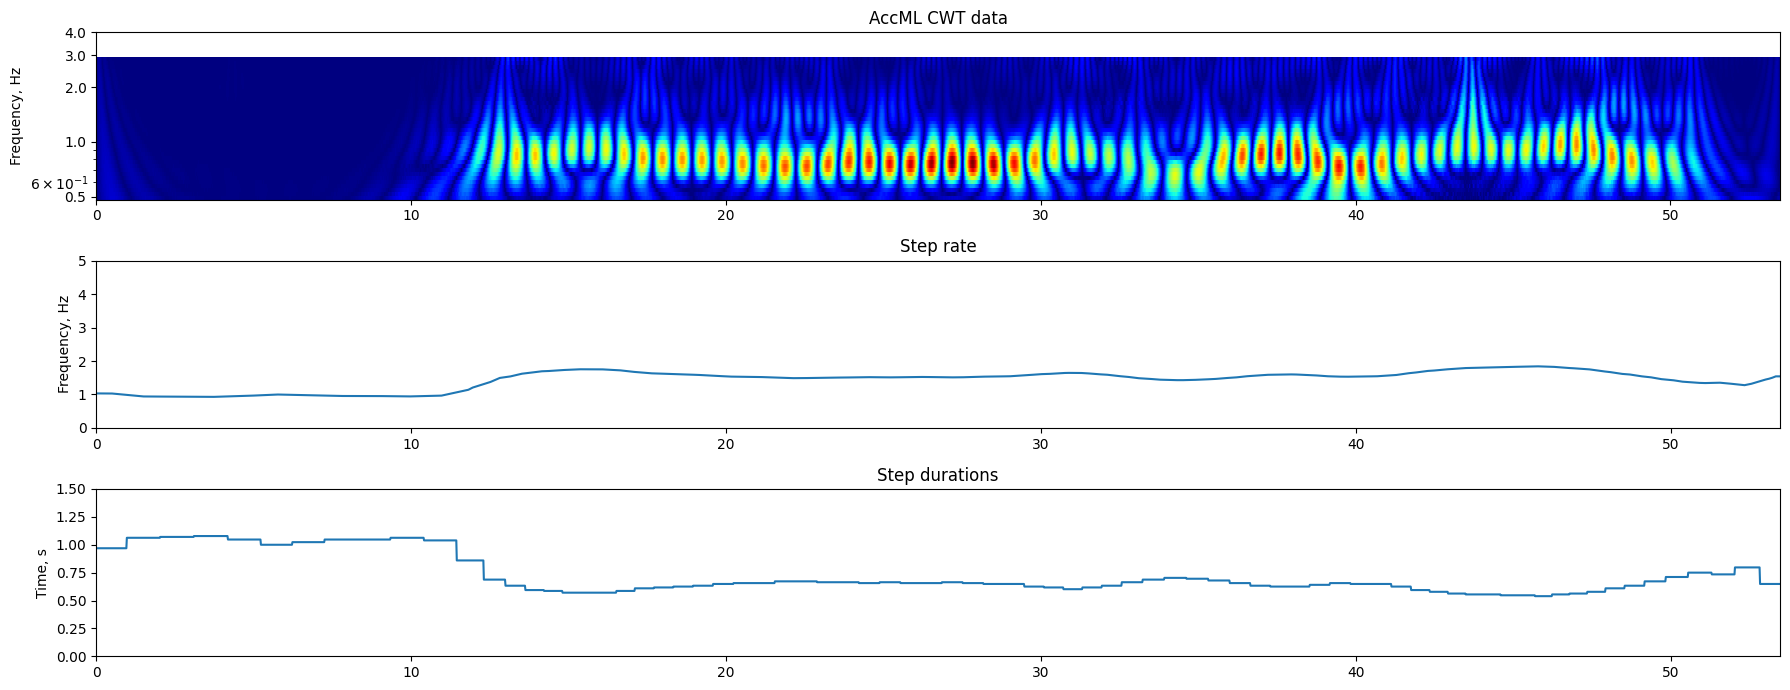

In [24]:
feature_display(df_tdcsfog.loc[200,'data'])

Min frequency = 0.4938077039387963
Max frequency = 2.8416671345184263


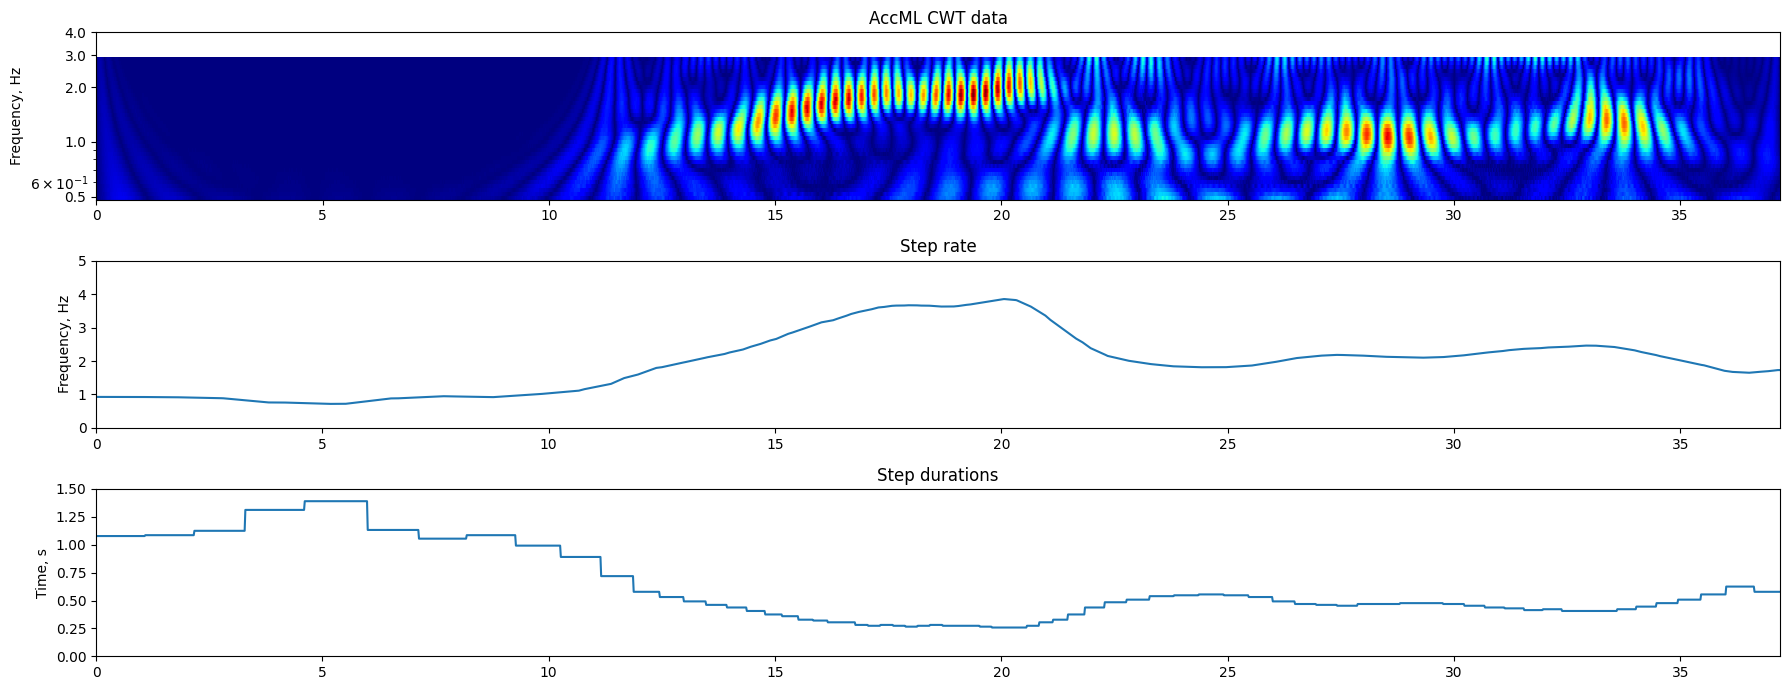

In [25]:
feature_display(df_tdcsfog.loc[307,'data'])

All of those seem to work correctly if we don't look at the parts where there is no walking. Some points with step_rate>3 are suspicios. I honestly tried to walk at step_rate=4. It's possible, but hard. But we have time series with that kind of frequencies being clearly visible, we have to identify them as step rate.

# 7. Conclusion <a name="Conclusion"></a>

* A resonably reliable procedure for locating individual steps is developed
* "Step rate" and "step durations" features are constructed
* A tool for visualizing steps is presented

#### Additionally
* created CWT images might help constructing other features
* some parts of those images actually correlate with FoG marks